### Fashion MNIST - Image Classification - with CNN 

**NOTE:** This notebook picks a model from a catalog of predefined neural network models based on the argument CURRENT_MODEL_IDX; trains the selected model; and saves it to a file. After training you should use **fashion-mnist_test** notebook to test the model.

Training takes about at least 4-5 mins to terminate. If you have no time for training, please run **fashion-mnist_test** notebook right away to see results. It loads my best model (CNN with dropout + image augmentation) from file and tests it.

Fashion Mnist is a dataset by Zalando Research to replace MNIST data.
It consists of 60K training, 10K test images, each of which are of size 785: 1 for the category, 784 for pixel RGB values (0-255). Each pixel contains only one value between 0-255. 

There are 10 categories:
- 0 => T-shirt/top
- 1 => Trouser
- 2 => Pullover
- 3 => Dress
- 4 => Coat
- 5 => Sandal
- 6 => Shirt
- 7 => Sneaker
- 8 => Bag
- 9 => Ankle boot

In this notebook I classify the data into one of those 10 categories (multiclass classification). 
I use Convolutional Neural Networks (CNN) to do so.

Whole process consists of the steps below:
- Loading data
- Preprocessing data
- Creating classification model
- Experiment with hyperparameter values to finetune the models (training and validation)
- Test the model's performance on the test data. 

**Note**
- **"create_dataframe"** method concatenates two arrays. Successive calls for that method during a single kernel connection will cause data size be larger than it should be. Please do not make multiple runs on the cells that call "create_dataframe" method.

**Clarifications**

- I preferred to use CNN because it is better in image recognition than DNN. CNN adds some layers to do convolution before the dense layers, this makes information going to the dense layers more focussed, and possibly more accurate.
- Here I use 0.2 of train data as validation data. Train data is still big enough (train: 48K, validation: 12K). I pick k=1 (k in kfold) for practical reasons such as avoiding too long training times. I think that k>1 won't make any big difference.
- I do validation simply to detect overfitting and finetune hyperparameters manually.

**TODO**
- Image augmentation (https://keras.io/preprocessing/image/, https://www.kaggle.com/stefanie04736/simple-keras-model-with-k-fold-cross-validation)
- make jupyter runnable via console inside docker
- update readme and docker

**Future work**
- apply random search for hyperparameter tuning (eg. **talos** library)
- apply resnet - rcnn

In [1]:
import numpy as np
import pandas as pd
import random
import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.python import keras as ks
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model, to_categorical
from keras.regularizers import l2,l1
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
import os
init_notebook_mode(connected=True)

Using TensorFlow backend.


Set **CURRENT_MODEL_IDX** to a value from the interval [0,6] according to the information below:
- 0: basic DNN, no convolution, no regularization, etc.
- 1: basic CNN, no regularization, etc.
- 2: CNN with dropout. (best)
- 3: CNN with dropout + L2 regularization.
- 4: CNN with dropout + stride number increased.
- 5: CNN with dropout + learning rate decay.
- 6: CNN with dropout + Nadam optimizer.

In [35]:
CURRENT_MODEL_IDX = 1
MODEL_OUT_DIR = 'saved_models'
MODEL_HISTORY_OUT_DIR = 'saved_model_histories'

**Set arguments**

In [3]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
seed = 13 # NOTE: this must be fixed across multiple runs of this notebook in order to produce the same train-validation split.
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

#Model hyperparameters
NO_EPOCHS = 10
#The larger the batch size, the more data your chunking into your memory that your model will train on. 
#The small the batch size, the less data, but your computation will be slower.
#It's a tradeoff between speed and memory.
BATCH_SIZE = 128
VAL_SIZE = 0.2

SHIFT_FRACTION = 0.005 # parameter for image augmentation

**Load data**

In [4]:
#x_train, x_test: uint8 array of grayscale image data with shape (num_samples, 28, 28).
#y_train, y_test: uint8 array of labels (integers in range 0-9) with shape (num_samples,).
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = fashion_mnist.load_data()

**Create dataframes from data - more practical for visualization**

In [5]:
# Create a dataframe from train data (x and y)
# merge label and pixel array,create a dataframe, of size (60000, 785). 
# Dataframe: 60000 rows. Each row holds label, pixel1, pixel2, ..., pixel784.
def create_dataframe(x_data,y_data):
    y_data_list = y_data.tolist()
    y_data_adjusted = np.array([y_data_list]) # needed step for contatenation
    num_images = x_data.shape[0] 
    x_data_array  = x_data.reshape(num_images, IMG_ROWS*IMG_COLS)
    data_array = np.concatenate((y_data_adjusted.T, x_data_array), axis=1)
    pixel_idx = range(1,IMG_ROWS*IMG_COLS+1) 
    pixel_names = ['pixel' + str(i) for i in pixel_idx]
    columns = ['label'] + pixel_names
    data_df = pd.DataFrame(data_array, columns = columns) 
    return data_df

In [6]:
train_data_df = create_dataframe(X_train_raw, y_train_raw)
test_data_df = create_dataframe(X_test_raw, y_test_raw)

In [7]:
print("Fashion MNIST train -  rows:",train_data_df.shape[0]," columns:", train_data_df.shape[1])
print("Fashion MNIST test -  rows:",test_data_df.shape[0]," columns:", test_data_df.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


**See how data looks like**

In [8]:
train_data_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**List unique labels**

In [9]:
unique_lbls = train_data_df.label.unique()
unique_labels_list = unique_lbls.tolist()
unique_labels_list.sort()
print('Labels: ', unique_labels_list)

Labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


**Check for null values**

In [10]:
print('Number of null values in train: ', train_data_df.isnull().any().sum())
print('Number of null values in test: ', test_data_df.isnull().any().sum())

Number of null values in train:  0
Number of null values in test:  0


**View random images**

'\nRemember that the labels are:\n- 0 => T-shirt/top\n- 1 => Trouser\n- 2 => Pullover\n- 3 => Dress\n- 4 => Coat\n- 5 => Sandal\n- 6 => Shirt\n- 7 => Sneaker\n- 8 => Bag\n- 9 => Ankle boot\n'

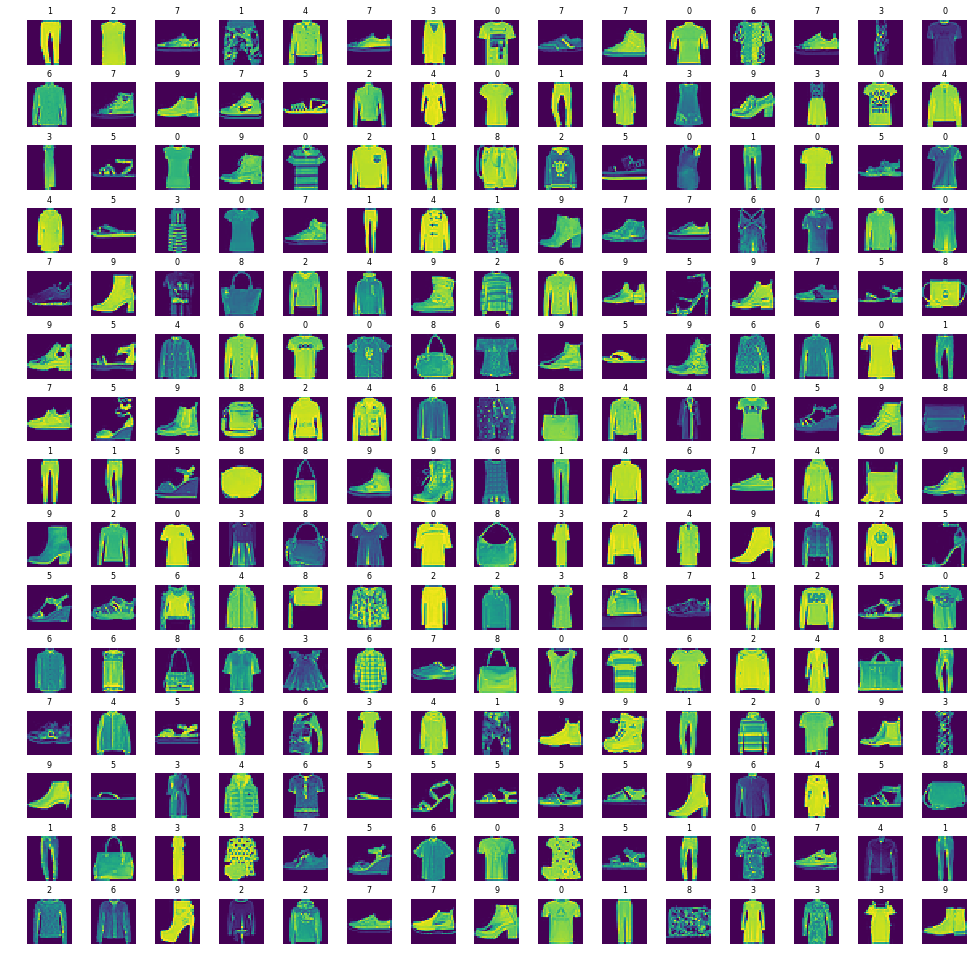

In [11]:
W_grid = 15
L_grid = 15
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

train_data_array = train_data_df.values[:,:]
n_training = len(train_data_array) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow(train_data_array[index,1:].reshape((28,28)) )
    axes[i].set_title(train_data_array[index,0], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

'''
Remember that the labels are:
- 0 => T-shirt/top
- 1 => Trouser
- 2 => Pullover
- 3 => Dress
- 4 => Coat
- 5 => Sandal
- 6 => Shirt
- 7 => Sneaker
- 8 => Bag
- 9 => Ankle boot
'''

**Check class balance**

In [12]:
train_data_df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [13]:
test_data_df['label'].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

Train and test data is balanced.

**Preprocess the data**
- **One-hot encode** the labels.
- **Reshape** the images from 785 to 28,28,1 where 1 is an extra dimension that CNN wants for channels.
- **Normalize** the data with zero mean. (divide by max = 255) (this accelerates train computations.)
- **Image augmentation**

In [14]:
# data preprocessing
def data_preprocessing(data):
    out_y = to_categorical(data.label, NUM_CLASSES)
    num_images = data.shape[0]
    x_as_array = data.values[:,1:] # take all rows, take columns except the first column (label)
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [15]:
# prepare the data
X_train, y_train = data_preprocessing(train_data_df)
#print(len(X[0][:][:][0]))
X_test, y_test = data_preprocessing(test_data_df)

**Split train data into train and validation - no cross validation. Just 1 fold.**

In [16]:
RANDOM_STATE = np.random.seed(seed)
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
split_indices = list(sss.split(X_train, y_train))
train_index = split_indices[0][0]
val_index = split_indices[0][1]

X_train_train, X_train_val = X_train[train_index], X_train[val_index]
y_train_train, y_train_val = y_train[train_index], y_train[val_index]

In [17]:
print("Fashion MNIST train -  rows:",X_train_train.shape[0]," columns:", X_train_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_train_val.shape[0]," columns:", X_train_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


**Apply image augmentation to train and validation sets.**
- Shift by 0.005 of height and width. 
- Randomly flip inputs horizontally

Image augmentation:
- Increases training data size.
- Helps model learn features that are invariant to the position/direction of the object.



In [18]:
gen = ImageDataGenerator(width_shift_range=SHIFT_FRACTION,height_shift_range=SHIFT_FRACTION,horizontal_flip=True)
batches = gen.flow(X_train_train, y_train_train, batch_size= BATCH_SIZE)
val_batches = gen.flow(X_train_val, y_train_val, batch_size= BATCH_SIZE)

**Train function**

In [19]:
#train function
def train(model):
    train_start = time.time()
    train_history = model.fit_generator(batches,
                        steps_per_epoch=X_train_train.shape[0]//BATCH_SIZE, 
                        epochs=NO_EPOCHS,validation_data=val_batches, 
                        validation_steps=X_train_val.shape[0]//BATCH_SIZE, 
                        use_multiprocessing=True)
    train_end = time.time()
    train_time = train_end-train_start
    return [train_time,train_history]

**Plotting functions** Plotting accuracy and loss change on train and validation sets.

In [20]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    
    iplot(fig, filename='accuracy-loss')

**Model catalog**

I create several models and picked best of them at the end to run at test data.

The models consist of several subsets of the properties below:

- optimizer: Adam, SGD, Nadam
- convolution layer
    - number of strides
- dropout 
- l1-regularization
- l2-regularization 
- learning rate decay
- momentum

**Basic Models:** no dropout, no batch normalization, no learning rate decay. Parameters left as their default values.

**Model 0: Basic DNN (not CNN)**

In [21]:
# Model 0: DNN
dnn_model = Sequential()
# Add convolution 2D
dnn_model.add(Flatten(input_shape=(IMG_ROWS, IMG_COLS, 1))) # we need yo specify input_shape in the first layer. Otherwise model does noy build.
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.
dnn_model.compile(loss=ks.losses.categorical_crossentropy,
              metrics=['accuracy'], optimizer=optim)
dnn_model.build()
dnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


**Model 1: Basic CNN:** 

In [22]:
#CNN
cnn1_model = Sequential()
cnn1_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1)))
cnn1_model.add(MaxPooling2D((2, 2)))
cnn1_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=1))
cnn1_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn1_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn1_model.add(Flatten())
cnn1_model.add(Dense(128, activation='relu'))
cnn1_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.
cnn1_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
__________

**Increase performance** with

- **Regularization** (Dropout, change number of strides, L1, L2,Batch normalization,Weight normalization)
     - avoids overfitting.
- **Optimization** (Learning rate decay, momentum)
    - increase chances of model reaching global optima
    - reach global optima faster

**Model 2: CNN with dropout**

In [23]:
#CNN with dropout.
#Add dropout layers after Conv2d layers and Dense layers. Do not add after the last Dense layer.
cnn2_model = Sequential()
cnn2_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1)))
cnn2_model.add(MaxPooling2D((2, 2)))
#cnn1_model.add(Dropout(0.25))
cnn2_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=1))
cnn2_model.add(MaxPooling2D(pool_size=(2, 2)))
#cnn1_model.add(Dropout(0.25))
cnn2_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn2_model.add(Dropout(0.25))
cnn2_model.add(Flatten())
cnn2_model.add(Dense(128, activation='relu'))
cnn2_model.add(Dropout(0.25))
cnn2_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.
cnn2_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn2_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0         
___________________________

**Model 4: CNN with dropout + L2 regularization**

**L2:**
- Penalizes high values more than smaller ones.
- heavily penalizes peaky weight vectors and prefers diffuse weight vectors. 
- Encourages the network to use all of its inputs a little rather than some of its inputs a lot

**L1:**
- Leads the weight vectors to become sparse during optimization
- Feature selection
- Use if you have too many features and aim to reduce their number.

_Feature selection is not in my main focus here so I do not prefer L1._

In [24]:
#CNN with dropout + L2 regularization
#Add L2 regularization to Conv2d layers and Dense layers. Do not add to the last Dense layer.
cnn3_model = Sequential()
l2_val = 0.0001
cnn3_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1),
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn3_model.add(MaxPooling2D((2, 2)))
cnn3_model.add(Dropout(0.25))
cnn3_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=1,
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn3_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn3_model.add(Dropout(0.25))
cnn3_model.add(Conv2D(128, (3, 3), activation='relu',
                         kernel_regularizer=l2(l2_val), 
                         bias_regularizer=l2(l2_val)))
cnn3_model.add(Dropout(0.4))
cnn3_model.add(Flatten())
cnn3_model.add(Dense(128, activation='relu',
                        kernel_regularizer=l2(l2_val), 
                        bias_regularizer=l2(l2_val)))
cnn3_model.add(Dropout(0.3))
cnn3_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.
cnn3_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         73856     
__________

#### Increasing Stride size

- To decrease computational complexity. (people usually increase strides of layers closer to the output, because in these layers computational is more.)
- To increase generality of the model. 

##### Results
- Strides=2 in top Conv2d layer: validaiton acc 0.90, validation loss: 0.26 (increased from 0.25 to 0.26 at the last epoch, so a slight overfitting is observed.)
- Strides=4 in top Conv2d layer: validaiton acc 0.87, validation loss: 0.36 (significant decrease in performance)
- Train acc decreased.
- Could not increase generality.

In [25]:
#CNN with dropout + more strides
#Add L2 regularization to Conv2d layers and Dense layers. Do not add to the last Dense layer.
cnn4_model = Sequential()
l2_val = 0.0001
cnn4_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1),
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn4_model.add(MaxPooling2D((2, 2)))
cnn4_model.add(Dropout(0.25))
cnn4_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=2,
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn4_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn4_model.add(Dropout(0.25))
cnn4_model.add(Conv2D(128, (3, 3), activation='relu',
                         kernel_regularizer=l2(l2_val), 
                         bias_regularizer=l2(l2_val)))
cnn4_model.add(Dropout(0.25))
cnn4_model.add(Flatten())
cnn4_model.add(Dense(128, activation='relu',
                        kernel_regularizer=l2(l2_val), 
                        bias_regularizer=l2(l2_val)))
cnn4_model.add(Dropout(0.25))
cnn4_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.
cnn4_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 128)         73856     
__________

#### Learning Rate Decay
- If learning rate is too high, model will take unnecessarily big steps on the gradient curve, it could cause jumping over the global optima. In this case reaching global optima takes unnecessarily long.
- If learning rate is too small, model might settle in a region (local optima) too early, this also causes the training take longer time.

- Decreasing learning rate: When we are finally really close to global optima, if learning rate is not sufficiently small, we might wander around the global optima and never reach it. But if we do learning rate decay, our steps get smaller when approaching global optima; and we can reach it.

- Learning rate decay reduces training time, if we set it up wisely.

**Results**
- Did not prevent overfitting.


In [26]:
#CNN with dropout + L2 regularization
#Add L2 regularization to Conv2d layers and Dense layers. Do not add to the last Dense layer.
cnn5_model = Sequential()
l2_val = 0.0001
cnn5_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1),
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn5_model.add(MaxPooling2D((2, 2)))
cnn5_model.add(Dropout(0.25))
cnn5_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=1,
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn5_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn5_model.add(Dropout(0.25))
cnn5_model.add(Conv2D(128, (3, 3), activation='relu',
                         kernel_regularizer=l2(l2_val), 
                         bias_regularizer=l2(l2_val)))
cnn5_model.add(Dropout(0.25))
cnn5_model.add(Flatten())
cnn5_model.add(Dense(128, activation='relu',
                        kernel_regularizer=l2(l2_val), 
                        bias_regularizer=l2(l2_val)))
cnn5_model.add(Dropout(0.25))
cnn5_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Adam(lr=0.002, decay=0.5) # these are default values in Adam's documentation.
cnn5_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 128)         73856     
__________

#### Nadam (Adam with Nesterov Momentum)

In [27]:
#CNN with dropout + L2 regularization
#Add L2 regularization to Conv2d layers and Dense layers. Do not add to the last Dense layer.
cnn6_model = Sequential()
l2_val = 0.0001
cnn6_model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1),
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn6_model.add(MaxPooling2D((2, 2)))
cnn6_model.add(Dropout(0.25))
cnn6_model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu',strides=1,
                     kernel_regularizer=l2(l2_val), 
                     bias_regularizer=l2(l2_val)))
cnn6_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn6_model.add(Dropout(0.25))
cnn6_model.add(Conv2D(128, (3, 3), activation='relu',
                         kernel_regularizer=l2(l2_val), 
                         bias_regularizer=l2(l2_val)))
cnn6_model.add(Dropout(0.25))
cnn6_model.add(Flatten())
cnn6_model.add(Dense(128, activation='relu',
                        kernel_regularizer=l2(l2_val), 
                        bias_regularizer=l2(l2_val)))
cnn6_model.add(Dropout(0.25))
cnn6_model.add(Dense(NUM_CLASSES, activation='softmax'))
optim = ks.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004) # these are default values in Nadam's documentation.
cnn6_model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn6_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 128)         73856     
__________

**Pick current model**

In [36]:
model_type_str = 'dnn' if CURRENT_MODEL_IDX==0 else 'cnn'
idx_str = str(CURRENT_MODEL_IDX) if CURRENT_MODEL_IDX>0 else ''
current_model_name = model_type_str+idx_str+'_model'
current_model = eval(current_model_name)

In [37]:
current_model_name

'cnn1_model'

In [38]:
current_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
__________

**Train current model**

In [39]:
current_train_time, current_model_history = train(current_model)

Epoch 1/10
375/375 [==============================] - 35s 95ms/step - loss: 0.5551 - acc: 0.7967 - val_loss: 0.3980 - val_acc: 0.8533
Epoch 2/10
375/375 [==============================] - 36s 96ms/step - loss: 0.3580 - acc: 0.8700 - val_loss: 0.3438 - val_acc: 0.8758
Epoch 3/10
375/375 [==============================] - 35s 94ms/step - loss: 0.3113 - acc: 0.8849 - val_loss: 0.3098 - val_acc: 0.8905
Epoch 4/10
375/375 [==============================] - 34s 91ms/step - loss: 0.2771 - acc: 0.8983 - val_loss: 0.2955 - val_acc: 0.8957
Epoch 5/10
375/375 [==============================] - 34s 90ms/step - loss: 0.2596 - acc: 0.9042 - val_loss: 0.2778 - val_acc: 0.9009
Epoch 6/10
375/375 [==============================] - 34s 91ms/step - loss: 0.2377 - acc: 0.9129 - val_loss: 0.2755 - val_acc: 0.8976
Epoch 7/10
375/375 [==============================] - 34s 91ms/step - loss: 0.2264 - acc: 0.9169 - val_loss: 0.2799 - val_acc: 0.9028
Epoch 8/10
375/375 [==============================] - 34s 90ms

**Save current model**

In [40]:
current_model.save(MODEL_OUT_DIR + '/' + current_model_name+'.h5')

**Save current model's training history**

In [41]:
current_hist_df = pd.DataFrame.from_dict(current_model_history.history)
current_hist_name = current_model_name + '_history'
current_hist_df.to_json (MODEL_HISTORY_OUT_DIR + '/' + current_hist_name+'.json', orient='records')

### References
- Stanford's online CNN course: http://cs231n.github.io/
- Kaggle challenge about Fashion-MNIST: https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist
- Image augmentation: https://keras.io/preprocessing/image/
- About L2 regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/